##Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Input,LSTM,Dense,SimpleRNN,Dropout,GRU,Bidirectional,LayerNormalization
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
!pip install reservoirpy
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import datetime
import seaborn as sns
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import time

#Data Processing

In [2]:
news=pd.read_excel("/content/News.xlsx")
news[["Date","Author"]]=news["Date"].str.split('|', expand=True)
news=news.drop(columns=["Author"])
news.set_index("Date",inplace=True)
news.index=pd.to_datetime(news.index,format="mixed").strftime("%d-%m-%Y")
news.head()

,Headline
Date,
21-06-2024,California Senator Revives $15 Billion Oil Div...
21-06-2024,India's Oil Imports Surge: Russia Hits Record ...
21-06-2024,Gas Flows to Sabine Pass LNG Export Plant Drop...
21-06-2024,Norway To Consider Developing Nuclear Energy
21-06-2024,India Seeks Tighter Regulatory Control Over LN...


In [3]:
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', force_download=True)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
def calculate_sentiment(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = scores[:, 1].item()
    return sentiment_score

# Apply the function to each row in the DataFrame
news['sentiment_score'] = news['Headline'].apply(calculate_sentiment)

# Print the resulting DataFrame with sentimental scores
news=news.drop(columns=["Headline"])
news.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

,sentiment_score
Date,
21-06-2024,0.000073
21-06-2024,0.999982
21-06-2024,0.000001
21-06-2024,0.000018
21-06-2024,0.999055


In [23]:
news.index = pd.to_datetime(news.index)
news = news.resample('D').mean()
news.index=news.index.strftime("%d-%m-%Y")
news.head()
df = yf.download('CL=F', start='2011-06-15', end='2024-06-21')
df=df[["Open","Adj Close"]]
df.index = pd.to_datetime(df.index)
df.index=df.index.strftime("%d-%m-%Y")
df=df.join(news)
df=df.dropna()
df.head()
df=df.dropna()
df.head()
M=df["Adj Close"].mean()
S=df["Adj Close"].std()
df["Open"]=(df["Open"]-df["Open"].mean())/df["Open"].std()
df["Adj Close"]=(df["Adj Close"]-df["Adj Close"].mean())/df["Adj Close"].std()
df["Open*Score"]=df["Open"]*df["sentiment_score"]
df["lag price"]=df["Adj Close"].shift(1)
df=df.drop(columns=["Open","sentiment_score"])
df=df.dropna()
df.head()

<ipython-input-23-01a7798b8949>:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  news.index = pd.to_datetime(news.index)
[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open*Score,lag price
Date,,,
16-06-2011,1.146770,0.000982,1.140380
20-06-2011,1.069634,0.000015,1.146770
21-06-2011,1.076024,0.000017,1.069634
22-06-2011,1.167766,0.000201,1.076024
23-06-2011,0.967394,0.220168,1.167766


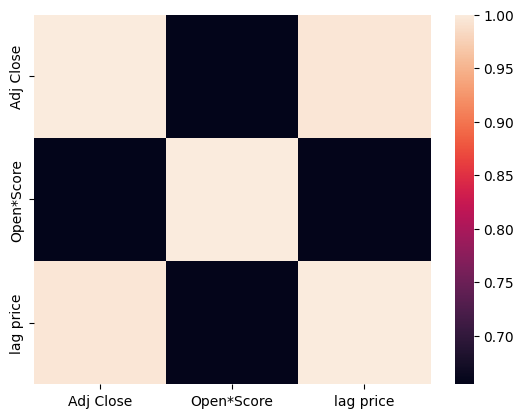

In [26]:
sns.heatmap(df.corr());

#Train and Test Dataset

In [33]:
X=df.drop("Adj Close",axis=1)
Y=df["Adj Close"]
X=X.to_numpy()
X_train,X_test=X[:-48],X[-48:]
Y_train,Y_test=Y[:-48],Y[-48:]
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
Y_train=np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test=np.reshape(Y_test, (Y_test.shape[0],1))
Y_test.shape

(48, 1)

#Simple RNN

In [36]:
RNN=Sequential()
RNN.add(SimpleRNN(units = 20,input_shape = (X_train.shape[1],1)))
RNN.add(Dense(units = 1))
RNN.compile(loss = "mean_squared_error")
T1=time.time()
RNN.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
RNN.summary()
T_RNN=T2-T1
Y_RNN = RNN.predict(X_test)
Y_RNN

Epoch 1/20
155/155 [==============================] - 2s 5ms/step - loss: 0.2047
Epoch 2/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 3/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0107
Epoch 4/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0095
Epoch 5/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 6/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0086
Epoch 7/20
155/155 [==============================] - 1s 8ms/step - loss: 0.0084
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0083
Epoch 9/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0083
Epoch 10/20
155/155 [==============================] - 2s 10ms/step - loss: 0.0081
Epoch 11/20
155/155 [==============================] - 1s 4ms/step - loss: 0.0082
Epoch 12/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0081
Epoch 13/20
155/155 [=

array([[0.67346215],
       [0.7028982 ],
       [0.69042665],
       [0.6892691 ],
       [0.5669267 ],
       [0.5693742 ],
       [0.5897296 ],
       [0.5732613 ],
       [0.5955668 ],
       [0.57170177],
       [0.6056959 ],
       [0.62054676],
       [0.5641892 ],
       [0.53333336],
       [0.4000074 ],
       [0.39846212],
       [0.3598253 ],
       [0.3784377 ],
       [0.37040785],
       [0.39858463],
       [0.414459  ],
       [0.36787468],
       [0.40346313],
       [0.3586196 ],
       [0.38100523],
       [0.4097118 ],
       [0.45068818],
       [0.43791133],
       [0.4142227 ],
       [0.33715785],
       [0.3041345 ],
       [0.33950788],
       [0.43933052],
       [0.41008833],
       [0.35290778],
       [0.31234556],
       [0.18656838],
       [0.14330894],
       [0.18035142],
       [0.24310291],
       [0.24224907],
       [0.34297633],
       [0.35336483],
       [0.38029012],
       [0.38469884],
       [0.37672293],
       [0.46150213],
       [0.513

#Deep RNN

In [51]:
SRNN=Sequential()
SRNN.add(SimpleRNN(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1)))
SRNN.add(Dropout(0.1))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20))
SRNN.add(Dense(units = 1,activation='linear'))
SRNN.compile(loss = "mean_squared_error")
T1=time.time()
SRNN.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
T_SRNN=T2-T1
SRNN.summary()
Y_SRNN = SRNN.predict(X_test)
Y_SRNN

Epoch 1/20
155/155 [==============================] - 8s 7ms/step - loss: 0.0679
Epoch 2/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0252
Epoch 3/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0218
Epoch 4/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0200
Epoch 5/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0200
Epoch 6/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0180
Epoch 7/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0175
Epoch 8/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0176
Epoch 9/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0159
Epoch 10/20
155/155 [==============================] - 1s 8ms/step - loss: 0.0161
Epoch 11/20
155/155 [==============================] - 1s 8ms/step - loss: 0.0164
Epoch 12/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0155
Epoch 13/20
155/155 [====

array([[0.5807453 ],
       [0.6082854 ],
       [0.6010239 ],
       [0.59510076],
       [0.47906125],
       [0.48033208],
       [0.49744996],
       [0.48731104],
       [0.51256955],
       [0.48513165],
       [0.5202757 ],
       [0.5290837 ],
       [0.47643977],
       [0.44529417],
       [0.31812772],
       [0.31586283],
       [0.27960533],
       [0.29551268],
       [0.2917116 ],
       [0.31795806],
       [0.3292186 ],
       [0.28600892],
       [0.32410175],
       [0.2757104 ],
       [0.3029404 ],
       [0.3282843 ],
       [0.36381075],
       [0.3525904 ],
       [0.3292162 ],
       [0.25625336],
       [0.22607905],
       [0.26358867],
       [0.35388637],
       [0.32817197],
       [0.27092758],
       [0.2313819 ],
       [0.11246216],
       [0.07106026],
       [0.10611974],
       [0.16938397],
       [0.16851786],
       [0.2636348 ],
       [0.2705495 ],
       [0.29640868],
       [0.30155715],
       [0.29421282],
       [0.37559003],
       [0.433

#Heirarichal RNN

In [39]:
input=Input(shape = (X_train.shape[1],1))
RNN1=SimpleRNN(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1))
RNN_1=RNN1(input)
RNN2=SimpleRNN(units = 20)
RNN_2=RNN2(RNN_1)
Output=Dense(units = 1)
Output=Output(RNN_2)
HRNN=Model(inputs=input,outputs=Output)
HRNN.compile(loss = "mean_squared_error")
T1=time.time()
HRNN.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
HRNN.summary()
T_HRNN=T2-T1
Y_HRNN = HRNN.predict(X_test)
Y_HRNN

Epoch 1/20
155/155 [==============================] - 7s 4ms/step - loss: 0.0662
Epoch 2/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0111
Epoch 3/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0094
Epoch 4/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 5/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0089
Epoch 6/20
155/155 [==============================] - 1s 4ms/step - loss: 0.0089
Epoch 7/20
155/155 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 8/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 9/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 10/20
155/155 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 11/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 12/20
155/155 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 13/20
155/155 [====

array([[0.6717792 ],
       [0.70032394],
       [0.6936492 ],
       [0.68631893],
       [0.56520355],
       [0.5658557 ],
       [0.58125216],
       [0.5744284 ],
       [0.6002409 ],
       [0.57205796],
       [0.6088212 ],
       [0.6167365 ],
       [0.5624607 ],
       [0.52879685],
       [0.39702272],
       [0.3940174 ],
       [0.35717416],
       [0.3717801 ],
       [0.37085313],
       [0.39761728],
       [0.40575337],
       [0.36260617],
       [0.40456134],
       [0.35041124],
       [0.3827992 ],
       [0.40811867],
       [0.44147938],
       [0.4310056 ],
       [0.40600842],
       [0.3315447 ],
       [0.3018536 ],
       [0.342363  ],
       [0.43228006],
       [0.4077028 ],
       [0.34624195],
       [0.30470502],
       [0.18421751],
       [0.1418204 ],
       [0.17730582],
       [0.24492802],
       [0.24401094],
       [0.34082627],
       [0.34494132],
       [0.37172168],
       [0.3780809 ],
       [0.37080377],
       [0.45531714],
       [0.517

#LSTM

In [40]:
lstm=Sequential()
lstm.add(LSTM(units = 20,input_shape = (X_train.shape[1],1)))
lstm.add(Dense(units = 1))
lstm.compile(loss = "mean_squared_error")
T1=time.time()
lstm.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
lstm.summary()
T_LSTM=T2-T1
Y_LSTM = lstm.predict(X_test)
Y_LSTM

Epoch 1/20
155/155 [==============================] - 4s 5ms/step - loss: 0.7042
Epoch 2/20
155/155 [==============================] - 1s 4ms/step - loss: 0.1311
Epoch 3/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0331
Epoch 4/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0175
Epoch 5/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0106
Epoch 6/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0094
Epoch 7/20
155/155 [==============================] - 2s 10ms/step - loss: 0.0092
Epoch 8/20
155/155 [==============================] - 1s 10ms/step - loss: 0.0090
Epoch 9/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 10/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 11/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 12/20
155/155 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 13/20
155/155 [==

2/2 [==============================] - 2s 18ms/step


array([[0.7383345 ],
       [0.7687215 ],
       [0.7527763 ],
       [0.7550027 ],
       [0.629214  ],
       [0.63236064],
       [0.65470475],
       [0.6345155 ],
       [0.65539485],
       [0.6332821 ],
       [0.66668016],
       [0.6850685 ],
       [0.62639797],
       [0.59546065],
       [0.45634925],
       [0.45503458],
       [0.4141477 ],
       [0.434411  ],
       [0.42455155],
       [0.4543864 ],
       [0.47252947],
       [0.4230842 ],
       [0.45891878],
       [0.41377795],
       [0.43527293],
       [0.4661708 ],
       [0.51052564],
       [0.49678314],
       [0.47220823],
       [0.3908009 ],
       [0.35543302],
       [0.39155003],
       [0.4982928 ],
       [0.46675634],
       [0.40755183],
       [0.36486596],
       [0.23071675],
       [0.184471  ],
       [0.2241674 ],
       [0.29018378],
       [0.28929082],
       [0.39633924],
       [0.40826753],
       [0.43663415],
       [0.44098255],
       [0.43249106],
       [0.52126735],
       [0.571

#Deep LSTM

In [41]:
SLSTM=Sequential()
SLSTM.add(LSTM(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1)))
SLSTM.add(Dropout(0.1))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20))
SLSTM.add(Dense(units = 1))
SLSTM.compile(loss = "mean_squared_error")
T1=time.time()
SLSTM.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
SLSTM.summary()
T_SLSTM=T2-T1
Y_SLSTM = SLSTM.predict(X_test)
Y_SLSTM

Epoch 1/20
155/155 [==============================] - 12s 13ms/step - loss: 0.8073
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.1122
Epoch 3/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0501
Epoch 4/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0221
Epoch 5/20
155/155 [==============================] - 2s 11ms/step - loss: 0.0184
Epoch 6/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0161
Epoch 7/20
155/155 [==============================] - 3s 22ms/step - loss: 0.0149
Epoch 8/20
155/155 [==============================] - 2s 16ms/step - loss: 0.0135
Epoch 9/20
155/155 [==============================] - 1s 10ms/step - loss: 0.0137
Epoch 10/20
155/155 [==============================] - 1s 9ms/step - loss: 0.0126
Epoch 11/20
155/155 [==============================] - 2s 10ms/step - loss: 0.0129
Epoch 12/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0132
Epoch 13/20
1

2/2 [==============================] - 4s 7ms/step


array([[0.64553535],
       [0.6747828 ],
       [0.65979606],
       [0.6614382 ],
       [0.5408169 ],
       [0.54363096],
       [0.5640438 ],
       [0.54601175],
       [0.5658082 ],
       [0.54481727],
       [0.57674116],
       [0.5939672 ],
       [0.53813314],
       [0.50842726],
       [0.37773672],
       [0.37636137],
       [0.33847734],
       [0.35685766],
       [0.34835762],
       [0.3760605 ],
       [0.39209825],
       [0.34650224],
       [0.38038248],
       [0.33743143],
       [0.35837334],
       [0.3870188 ],
       [0.42758894],
       [0.41508397],
       [0.3918801 ],
       [0.3164838 ],
       [0.28413403],
       [0.31782812],
       [0.41647726],
       [0.38750556],
       [0.33188197],
       [0.292177  ],
       [0.16955607],
       [0.12744677],
       [0.16347899],
       [0.2244072 ],
       [0.22358407],
       [0.32199532],
       [0.33227757],
       [0.35863382],
       [0.36298397],
       [0.35517138],
       [0.4381669 ],
       [0.486

#Heirarichal LSTM

In [42]:
input=Input(shape = (X_train.shape[1],1))
RNN1=LSTM(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1))
RNN_1=RNN1(input)
RNN2=LSTM(units = 20)
RNN_2=RNN2(RNN_1)
Output=Dense(units = 1)
Output=Output(RNN_2)
HLSTM=Model(inputs=input,outputs=Output)
HLSTM.compile(loss = "mean_squared_error")
T1=time.time()
HLSTM.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
HLSTM.summary()
T_HLSTM=T2-T1
Y_HLSTM = HLSTM.predict(X_test)
Y_HLSTM

Epoch 1/20
155/155 [==============================] - 9s 5ms/step - loss: 0.4848
Epoch 2/20
155/155 [==============================] - 1s 4ms/step - loss: 0.0572
Epoch 3/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0223
Epoch 4/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0103
Epoch 5/20
155/155 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 6/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0087
Epoch 7/20
155/155 [==============================] - 1s 7ms/step - loss: 0.0084
Epoch 8/20
155/155 [==============================] - 1s 9ms/step - loss: 0.0083
Epoch 9/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0081
Epoch 10/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0081
Epoch 11/20
155/155 [==============================] - 1s 9ms/step - loss: 0.0081
Epoch 12/20
155/155 [==============================] - 1s 6ms/step - loss: 0.0080
Epoch 13/20
155/155 [==

array([[0.6848702 ],
       [0.71562636],
       [0.69700825],
       [0.70207924],
       [0.5771632 ],
       [0.5809254 ],
       [0.60490286],
       [0.5812816 ],
       [0.60040075],
       [0.58037394],
       [0.6120536 ],
       [0.63294196],
       [0.57440835],
       [0.5452044 ],
       [0.41017857],
       [0.40936315],
       [0.36972228],
       [0.39029363],
       [0.37878218],
       [0.40770155],
       [0.4275478 ],
       [0.37902895],
       [0.41144955],
       [0.37105176],
       [0.38864812],
       [0.41917947],
       [0.4643724 ],
       [0.4503026 ],
       [0.4270724 ],
       [0.34832758],
       [0.31375852],
       [0.34671625],
       [0.45180762],
       [0.41997847],
       [0.36462048],
       [0.32425722],
       [0.1960413 ],
       [0.15242526],
       [0.19006333],
       [0.2510114 ],
       [0.25018418],
       [0.35260472],
       [0.3658563 ],
       [0.39303792],
       [0.3965745 ],
       [0.38822496],
       [0.47370481],
       [0.519

#ESN

In [44]:
rpy.verbosity(0)
rpy.set_seed(42)
reservoir = Reservoir(units=150, lr=0.75, sr=1.25,input_dim=2)
readout=Ridge(ridge=1e-5)
ESN = reservoir >> readout
T1=time.time()
ESN = ESN.fit(X_train, Y_train, warmup=50)
T2=time.time()
Y_ESN=ESN.run(X_test)
T_ESN=T2-T1
Y_ESN

array([[0.68644495],
       [0.70927392],
       [0.7012363 ],
       [0.69827442],
       [0.58520765],
       [0.60782152],
       [0.59327369],
       [0.58184004],
       [0.60876053],
       [0.57023332],
       [0.60834056],
       [0.62029085],
       [0.5605377 ],
       [0.54634533],
       [0.3939225 ],
       [0.40573948],
       [0.35189178],
       [0.38473101],
       [0.38097524],
       [0.41150851],
       [0.41388144],
       [0.3838343 ],
       [0.43407269],
       [0.35388272],
       [0.39556885],
       [0.41997563],
       [0.44504514],
       [0.44180016],
       [0.41175538],
       [0.32839551],
       [0.30487798],
       [0.34788399],
       [0.44086001],
       [0.41527371],
       [0.36398209],
       [0.31050575],
       [0.19508894],
       [0.15116713],
       [0.19566425],
       [0.27416453],
       [0.27047205],
       [0.37006807],
       [0.37391483],
       [0.39605242],
       [0.40402289],
       [0.38656003],
       [0.47524948],
       [0.535

#Heirarichal ESN

In [45]:
Node1 = Reservoir(units=150, lr=0.75, sr=1.25,name="N1")
Out1=Ridge(ridge=1e-5,name="O1")
Node2=Reservoir(units=150, lr=0.75, sr=1.25,name="N2")
Out2=Ridge(ridge=1e-5,name="O2")
model = Node1>>Out1>>Node2 >> Out2
T1=time.time()
model = model.fit(X_train, {"O1":Y_train,"O2": Y_train})
T2=time.time()
Y_HESN=model.run(X_test)
T_HESN=T2-T1
Y_HESN

array([[0.69543536],
       [0.72307799],
       [0.71898532],
       [0.69710461],
       [0.58545474],
       [0.6043192 ],
       [0.59065218],
       [0.58276679],
       [0.61273708],
       [0.57794533],
       [0.61658813],
       [0.61272574],
       [0.55427497],
       [0.54822727],
       [0.42430425],
       [0.41154308],
       [0.3555856 ],
       [0.36916873],
       [0.36651787],
       [0.41282148],
       [0.41130053],
       [0.36325136],
       [0.391405  ],
       [0.33287415],
       [0.36189428],
       [0.42170651],
       [0.43935499],
       [0.46162224],
       [0.43479629],
       [0.34995689],
       [0.31140834],
       [0.3145895 ],
       [0.39605385],
       [0.37831522],
       [0.36098921],
       [0.32288711],
       [0.21651236],
       [0.14133579],
       [0.15817004],
       [0.24400754],
       [0.25095233],
       [0.35112287],
       [0.34907641],
       [0.38999409],
       [0.40707016],
       [0.37561155],
       [0.45463052],
       [0.487

#Perfomance Comparison

In [52]:
pred=df.iloc[-48:,0].to_frame()
pred["Simple RNN"]=Y_RNN
pred["Deep RNN"]=Y_SRNN
pred["Heirarichal RNN"]=Y_HRNN
pred["LSTM"]=Y_LSTM
pred["Deep LSTM"]=Y_SLSTM
pred["Heirarichal LSTM"]=Y_HLSTM
pred["ESN"]=Y_ESN
pred["Heirarichal ESN"]=Y_HESN
pred

,Adj Close,Simple RNN,Deep RNN,Heirarichal RNN,LSTM,Deep LSTM,Heirarichal LSTM,ESN,Heirarichal ESN
Date,,,,,,,,,
12-04-2024,0.722748,0.673462,0.580745,0.671779,0.738334,0.645535,0.684870,0.686445,0.695435
15-04-2024,0.711337,0.702898,0.608285,0.700324,0.768722,0.674783,0.715626,0.709274,0.723078
16-04-2024,0.709055,0.690427,0.601024,0.693649,0.752776,0.659796,0.697008,0.701236,0.718985
17-04-2024,0.587189,0.689269,0.595101,0.686319,0.755003,0.661438,0.702079,0.698274,0.697105
18-04-2024,0.589015,0.566927,0.479061,0.565204,0.629214,0.540817,0.577163,0.585208,0.585455
19-04-2024,0.607728,0.569374,0.480332,0.565856,0.632361,0.543631,0.580925,0.607822,0.604319
22-04-2024,0.594491,0.589730,0.497450,0.581252,0.654705,0.564044,0.604903,0.593274,0.590652
23-04-2024,0.617769,0.573261,0.487311,0.574428,0.634516,0.546012,0.581282,0.581840,0.582767
24-04-2024,0.592666,0.595567,0.512570,0.600241,0.655395,0.565808,0.600401,0.608761,0.612737


In [57]:
def met(df):

    actual = df.iloc[:, 0]
    values = {
        'Model': [],
        'MSE': [],
        'RMSE': [],
        'R-squared': []
    }
    for c in df.columns[1:]:
        y_a = actual
        y_p = df[c]
        mse = mean_squared_error(y_a, y_p)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_a, y_p)
        values['Model'].append(c)
        values['MSE'].append(mse)
        values['RMSE'].append(rmse)
        values['R-squared'].append(r_squared)

    values = pd.DataFrame(values)
    values.set_index("Model",inplace=True)
    return values
perf=met(pred).round(4)
perf

,MSE,RMSE,R-squared
Model,,,
Simple RNN,0.0028,0.0532,0.8409
Deep RNN,0.0122,0.1103,0.3155
Heirarichal RNN,0.0028,0.0531,0.8414
LSTM,0.0045,0.0669,0.7481
Deep LSTM,0.0040,0.0636,0.7728
Heirarichal LSTM,0.0027,0.0520,0.8480
ESN,0.0025,0.0496,0.8618
Heirarichal ESN,0.0034,0.0580,0.8107


In [63]:
T=[T_RNN,T_SRNN,T_HRNN,T_LSTM,T_SLSTM,T_HLSTM,T_ESN,T_HESN]
perf["Time"]=T
perf

,MSE,RMSE,R-squared,Time
Model,,,,
Simple RNN,0.0028,0.0532,0.8409,21.868727
Deep RNN,0.0122,0.1103,0.3155,27.031500
Heirarichal RNN,0.0028,0.0531,0.8414,26.735364
LSTM,0.0045,0.0669,0.7481,23.725823
Deep LSTM,0.0040,0.0636,0.7728,50.031794
Heirarichal LSTM,0.0027,0.0520,0.8480,49.068025
ESN,0.0025,0.0496,0.8618,1.966948
Heirarichal ESN,0.0034,0.0580,0.8107,5.333511
